# Preparation

In [78]:
!pip install convokit
from convokit import Corpus, download
import numpy as np
import pandas as pd

corpus = Corpus(filename=download("movie-corpus"))
corpus.print_summary_stats()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [79]:
from tqdm import tqdm
def get_movie_utt_dic(corpus):
    '''
    get the dictionary of movies that map movies to corresponding utterances. 
    In chronological order. 
    '''
    movie_utt_dic = {}
    movie_idx_name = {}
    for utt in tqdm(corpus.iter_utterances()):
        if utt.meta['movie_id'] not in movie_utt_dic:
            movie_utt_dic[utt.meta['movie_id']] = []
            movie_idx_name[utt.meta['movie_id']] = utt.speaker.meta['movie_name']
        movie_utt_dic[utt.meta['movie_id']].append(int(utt.id[1:]))
    
    for movie, utt_lst in tqdm(movie_utt_dic.items()):
        id_lst = sorted(utt_lst)
        movie_utt_dic[movie] =  ['L' + str(i) for i in id_lst]
    
    return movie_utt_dic, movie_idx_name
        
movie_utt_dic, movie_idx_name = get_movie_utt_dic(corpus)

304713it [00:00, 475206.36it/s]
100%|██████████| 617/617 [00:00<00:00, 5370.05it/s]


In [80]:
utt_df = corpus.get_utterances_dataframe()
# del utt_df

In [81]:
conv = {}
conv_speaker = {}

for movie_id, utt_ids in movie_utt_dic.items():
  for utt_id in utt_ids:
    utt = corpus.get_utterance(utt_id)
    conv_id = utt.conversation_id
    
    if conv_id not in conv:
      conv[conv_id] = []
      conv_speaker[conv_id] = []
    conv[conv_id].append(utt.text)
    conv_speaker[conv_id].append(utt.speaker.id)

In [82]:
conv_gender_proportion = {}

for conv_id, speakers in conv_speaker.items():
  genders = []
  for speaker_id in speakers:
    gender = corpus.get_speaker(speaker_id).meta['gender']
    genders.append(gender)
  
  female_proportion = sum([1 for gender in genders if gender=='f'])/len(genders)
  conv_gender_proportion[conv_id] = female_proportion

In [83]:
conv_only_male = []
conv_less_female = []
conv_more_female = []
for conv_id, gender_proportion in conv_gender_proportion.items():
  if gender_proportion == 0:
    conv_only_male.append(conv[conv_id])
  elif gender_proportion <=0.5:
    conv_less_female.append(conv[conv_id])
  else:
    conv_more_female.append(conv[conv_id])
len(conv_only_male), len(conv_less_female), len(conv_more_female)

(51343, 23965, 7789)

In [84]:
conv_all = []
labels = []
for conv_id, gender_proportion in conv_gender_proportion.items():
  if gender_proportion == 0:
    conv_all.append(conv[conv_id])
    labels.append(1)
  elif gender_proportion <=0.5:
    conv_all.append(conv[conv_id])
    labels.append(2)
  else:
    conv_all.append(conv[conv_id])
    labels.append(3)
corpus_all= [' '.join(conv) for conv in conv_all]

In [85]:
corpus_only_male= [' '.join(conv) for conv in conv_only_male]
corpus_less_female= [' '.join(conv) for conv in conv_less_female]
corpus_more_female= [' '.join(conv) for conv in conv_more_female]
len(corpus_only_male), len(corpus_less_female), len(corpus_more_female)

(51343, 23965, 7789)

# Word2Vec training for each gropus

## Only Male

### Topic Modeling

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [ ]:
from gensim.parsing.preprocessing import preprocess_documents

In [ ]:
preprocessed_texts = preprocess_documents(corpus_only_male)
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
ldamodel.print_topics()

[(0,
  '0.023*"like" + 0.014*"got" + 0.011*"yeah" + 0.010*"littl" + 0.008*"man" + 0.007*"hei" + 0.007*"ain" + 0.007*"shit" + 0.007*"boi" + 0.006*"right"'),
 (1,
  '0.018*"know" + 0.018*"want" + 0.013*"man" + 0.013*"got" + 0.013*"kill" + 0.013*"fuck" + 0.008*"like" + 0.008*"gonna" + 0.008*"let" + 0.007*"talk"'),
 (2,
  '0.022*"ye" + 0.015*"sir" + 0.009*"thank" + 0.008*"good" + 0.006*"want" + 0.005*"know" + 0.005*"father" + 0.005*"love" + 0.005*"man" + 0.005*"friend"'),
 (3,
  '0.032*"know" + 0.015*"want" + 0.014*"think" + 0.014*"like" + 0.014*"go" + 0.014*"got" + 0.012*"come" + 0.011*"time" + 0.011*"right" + 0.011*"tell"'),
 (4,
  '0.012*"look" + 0.010*"right" + 0.008*"good" + 0.008*"know" + 0.007*"think" + 0.007*"like" + 0.005*"tell" + 0.005*"got" + 0.004*"minut" + 0.004*"let"')]

### Cleaned Version

In [156]:
from random import sample
corpus_only_male_sampled = sample(corpus_only_male,7789)
len(corpus_only_male_sampled)

7789

In [157]:
preprocessed_texts_only_male = preprocess_documents(corpus_only_male_sampled)

In [158]:
from gensim.models import Word2Vec


In [159]:
w2vmodel_only_male = Word2Vec(
        preprocessed_texts_only_male,
        size=7789,
        window=10)

In [ ]:
w2vmodel_only_male.wv.most_similar("power")

[('know', 0.9998112320899963),
 ('want', 0.9998075366020203),
 ('like', 0.9998071193695068),
 ('think', 0.9998059868812561),
 ('thing', 0.999805748462677),
 ('tell', 0.9998033046722412),
 ('right', 0.99980229139328),
 ('mean', 0.9998018145561218),
 ('go', 0.9998008012771606),
 ('ain', 0.999799370765686)]

In [ ]:
w2vmodel_only_male.wv.most_similar("woman")

[('know', 0.9999275803565979),
 ('want', 0.9999228715896606),
 ('like', 0.9999216794967651),
 ('thing', 0.9999200105667114),
 ('right', 0.9999197125434875),
 ('think', 0.9999188184738159),
 ('tell', 0.9999173879623413),
 ('mean', 0.999916136264801),
 ('ain', 0.9999158978462219),
 ('go', 0.9999153017997742)]

In [ ]:
w2vmodel_only_male.wv.most_similar("man")

[('know', 0.9999697804450989),
 ('like', 0.9999663829803467),
 ('want', 0.9999647736549377),
 ('thing', 0.9999642372131348),
 ('think', 0.9999624490737915),
 ('right', 0.9999620318412781),
 ('tell', 0.9999609589576721),
 ('mean', 0.9999608993530273),
 ('ain', 0.9999587535858154),
 ('go', 0.9999572038650513)]

In [ ]:
w2vmodel_only_male.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('know', 0.9997261762619019),
 ('want', 0.9997227191925049),
 ('think', 0.9997194409370422),
 ('like', 0.9997193217277527),
 ('thing', 0.9997186660766602),
 ('right', 0.9997168183326721),
 ('tell', 0.9997166991233826),
 ('go', 0.9997159242630005),
 ('mean', 0.9997143745422363),
 ('night', 0.9997139573097229)]

In [ ]:
w2vmodel_only_male.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('know', 0.9997163414955139),
 ('like', 0.9997145533561707),
 ('thing', 0.9997129440307617),
 ('want', 0.9997125864028931),
 ('think', 0.9997125864028931),
 ('tell', 0.999710202217102),
 ('mean', 0.9997091889381409),
 ('right', 0.9997076988220215),
 ('go', 0.9997057914733887),
 ('wai', 0.99970543384552)]

### Uncleaned Version

In [160]:
from random import sample
corpus_only_male_sampled = sample(corpus_only_male,7789)
len(corpus_only_male_sampled)

7789

In [161]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation

In [162]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

In [163]:
tokenized_texts = []
for conv in corpus_only_male_sampled:
  tokenized_texts.append(preprocess_string(conv, CUSTOM_FILTERS))

In [164]:
from gensim.models import Word2Vec
w2vmodel_only_male_uncleaned = Word2Vec(
        tokenized_texts,
        size=400,
        window=10)

In [ ]:
w2vmodel_only_male_uncleaned.wv.most_similar("she")

[('her', 0.8941872119903564),
 ('he', 0.7944333553314209),
 ('was', 0.7849247455596924),
 ('said', 0.7818982005119324),
 ('that', 0.7724723815917969),
 ('mother', 0.7437698245048523),
 ('sore', 0.7362278699874878),
 ('girl', 0.734960675239563),
 ('name', 0.7241322994232178),
 ('fixed', 0.7204688787460327)]

In [ ]:
w2vmodel_only_male_uncleaned.wv.most_similar("her")

[('she', 0.8941872119903564),
 ('said', 0.7781175971031189),
 ('suspicious', 0.7728043794631958),
 ('jealous', 0.761027455329895),
 ('marry', 0.7454886436462402),
 ('sore', 0.7334582805633545),
 ('when', 0.7311935424804688),
 ('mother', 0.730105459690094),
 ('girl', 0.7273238897323608),
 ('wheels', 0.7087754011154175)]

In [ ]:
w2vmodel_only_male_uncleaned.wv.most_similar("woman")

[('girl', 0.8070864677429199),
 ('lady', 0.7106090784072876),
 ('child', 0.6971492171287537),
 ('person', 0.696940541267395),
 ('herself', 0.6379427909851074),
 ('man', 0.5742233395576477),
 ('rose', 0.5598405599594116),
 ('her', 0.5497320890426636),
 ('nun', 0.5352122187614441),
 ('she', 0.5323839783668518)]

In [ ]:
w2vmodel_only_male_uncleaned.wv.most_similar("man")

[('boy', 0.5871012210845947),
 ('cop', 0.5850527882575989),
 ('woman', 0.5742233395576477),
 ('guy', 0.5730761885643005),
 ('cat', 0.572471559047699),
 ('monster', 0.5451343059539795),
 ('fellow', 0.5436459183692932),
 ('fool', 0.5432432293891907),
 ('fella', 0.5284389853477478),
 ('lady', 0.5208795666694641)]

In [ ]:
w2vmodel_only_male_uncleaned.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('so', 0.9999819993972778),
 ('they', 0.9999818205833435),
 ('of', 0.9999817609786987),
 ('to', 0.9999817609786987),
 ('your', 0.9999817609786987),
 ('some', 0.9999817609786987),
 ('we', 0.999981701374054),
 ('in', 0.999981701374054),
 ('with', 0.999981701374054),
 ('just', 0.9999816417694092)]

In [ ]:
w2vmodel_only_male_uncleaned.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('at', 0.9999813437461853),
 ('in', 0.9999812245368958),
 ('we', 0.9999811053276062),
 ('of', 0.9999811053276062),
 ('time', 0.9999810457229614),
 ('they', 0.9999810457229614),
 ('my', 0.9999810457229614),
 ('his', 0.9999810457229614),
 ('on', 0.9999810457229614),
 ('your', 0.9999810457229614)]

### Visualization

I only employed visualization on the not cleaned version of the Word2Vec, as it displays more differences based on gender

In [167]:
import sklearn

In [168]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [169]:
Gender = dimension(w2vmodel_only_male_uncleaned, ['man','him','he'], ['woman', 'her', 'she'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [152]:
occupation_and_family = ['police', 'doctor', 'captain', 'child', 'family', 'baby', 'mother']

verb_adj = ['hate', 'love', 'smart', 'young', 'old', 'beautiful']

expression_habit  = ['tell', 'want', 'need', 'think', 'got', 'fuck', 'know', 'feel', 'talk', 'thank']

In [154]:
def makeDF(model, word_list):
    g = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g}, index = word_list)
    return df

In [170]:
occupation_and_family_df = makeDF(w2vmodel_only_male_uncleaned, occupation_and_family) 
verb_adj_df = makeDF(w2vmodel_only_male_uncleaned, verb_adj) 
expression_habit_df = makeDF(w2vmodel_only_male_uncleaned, expression_habit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launch

In [171]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

##### Occupation and Family


In [ ]:
import matplotlib.pyplot as plt


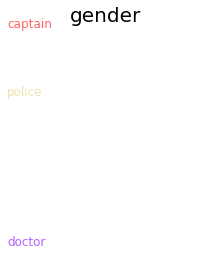

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, occupation_df, 'gender')
plt.show()

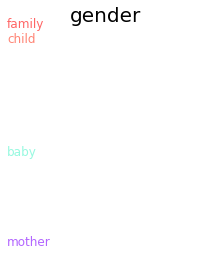

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, family_df, 'gender')
plt.show()

##### Verbs and Adjective


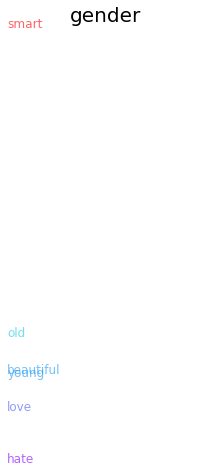

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, verb_adj_df, 'gender')
plt.show()

##### Expression Habbit


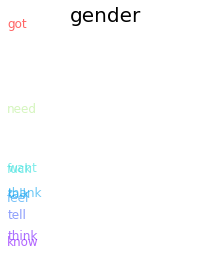

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, expression_habit_df, 'gender')
plt.show()

## Less Female

### Topic Modeling

In [ ]:
preprocessed_texts = preprocess_documents(corpus_less_female)
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
ldamodel.print_topics()

[(0,
  '0.020*"like" + 0.019*"know" + 0.013*"think" + 0.011*"got" + 0.011*"good" + 0.008*"time" + 0.007*"yeah" + 0.007*"look" + 0.007*"want" + 0.006*"tell"'),
 (1,
  '0.021*"like" + 0.019*"come" + 0.017*"know" + 0.016*"want" + 0.015*"go" + 0.012*"right" + 0.009*"look" + 0.009*"let" + 0.009*"think" + 0.008*"love"'),
 (2,
  '0.016*"know" + 0.010*"think" + 0.009*"year" + 0.008*"look" + 0.007*"like" + 0.007*"thing" + 0.007*"got" + 0.007*"thank" + 0.007*"time" + 0.006*"mean"'),
 (3,
  '0.022*"ye" + 0.021*"want" + 0.016*"like" + 0.014*"think" + 0.013*"right" + 0.012*"go" + 0.009*"talk" + 0.009*"tell" + 0.009*"know" + 0.008*"look"'),
 (4,
  '0.038*"know" + 0.014*"want" + 0.009*"gonna" + 0.009*"got" + 0.008*"think" + 0.008*"thing" + 0.007*"mean" + 0.007*"tell" + 0.007*"happen" + 0.007*"right"')]

### Cleaned

In [ ]:
from random import sample
corpus_less_female_sampled = sample(corpus_less_female,7789)
len(corpus_less_female_sampled)

7789

In [ ]:
preprocessed_texts_less_female = preprocess_documents(corpus_less_female_sampled)

In [ ]:
w2vmodel_less_female = Word2Vec(
        preprocessed_texts_less_female,
        size=7789,
        window=10)

In [ ]:
w2vmodel_less_female.wv.most_similar("love")

[('harri', 0.9999659061431885),
 ('true', 0.9999659061431885),
 ('fell', 0.9999657273292542),
 ('ye', 0.999964714050293),
 ('life', 0.9999637603759766),
 ('fall', 0.9999633431434631),
 ('man', 0.9999631643295288),
 ('crazi', 0.9999630451202393),
 ('save', 0.9999630451202393),
 ('real', 0.9999629855155945)]

In [ ]:
w2vmodel_less_female.wv.most_similar("woman")

[('know', 0.999927818775177),
 ('want', 0.9999231696128845),
 ('like', 0.999921977519989),
 ('thing', 0.9999199509620667),
 ('right', 0.9999197721481323),
 ('think', 0.9999192953109741),
 ('tell', 0.9999176859855652),
 ('mean', 0.9999165534973145),
 ('ain', 0.9999159574508667),
 ('go', 0.9999154210090637)]

In [ ]:
w2vmodel_less_female.wv.most_similar("man")

[('know', 0.9999697804450989),
 ('like', 0.9999666810035706),
 ('want', 0.9999649524688721),
 ('thing', 0.9999642372131348),
 ('think', 0.9999626278877258),
 ('right', 0.9999622106552124),
 ('tell', 0.999961256980896),
 ('mean', 0.9999610781669617),
 ('ain', 0.9999586939811707),
 ('go', 0.9999573826789856)]

In [ ]:
w2vmodel_less_female.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('know', 0.9997264742851257),
 ('want', 0.9997234344482422),
 ('like', 0.99972003698349),
 ('think', 0.9997199773788452),
 ('thing', 0.9997189044952393),
 ('right', 0.9997172355651855),
 ('tell', 0.999717116355896),
 ('go', 0.9997162818908691),
 ('mean', 0.9997148513793945),
 ('night', 0.9997144341468811)]

In [ ]:
w2vmodel_less_female.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('know', 0.9997166991233826),
 ('like', 0.9997149705886841),
 ('thing', 0.9997133612632751),
 ('want', 0.999713122844696),
 ('think', 0.9997127056121826),
 ('tell', 0.9997106790542603),
 ('mean', 0.9997096061706543),
 ('right', 0.9997081160545349),
 ('go', 0.9997060298919678),
 ('dai', 0.9997057318687439)]

### Not Cleaned

In [ ]:
from random import sample
corpus_less_female_sampled = sample(corpus_less_female,7789)
len(corpus_less_female_sampled)

7789

In [ ]:
tokenized_texts = []
for conv in corpus_less_female_sampled:
  tokenized_texts.append(preprocess_string(conv, CUSTOM_FILTERS))

In [ ]:
from gensim.models import Word2Vec
w2vmodel_less_female_uncleaned = Word2Vec(
        tokenized_texts,
        vector_size=7789,
        window=10)

In [ ]:
w2vmodel_less_female_uncleaned.wv.most_similar("woman")

[('granted', 0.9992688894271851),
 ('horror', 0.9988885521888733),
 ('flower', 0.9987589120864868),
 ('pink', 0.9982288479804993),
 ('named', 0.9982117414474487),
 ('blonde', 0.9981622099876404),
 ('age', 0.9981551766395569),
 ('terrified', 0.9980787634849548),
 ('book', 0.9980083107948303),
 ('times', 0.997382402420044)]

In [ ]:
w2vmodel_less_female_uncleaned.wv.most_similar("man")

[('image', 0.9945072531700134),
 ('coma', 0.9937885999679565),
 ('busted', 0.993058979511261),
 ('slut', 0.9921164512634277),
 ('has', 0.991152286529541),
 ('cousin', 0.9900646209716797),
 ('guy', 0.9890527725219727),
 ('recently', 0.9872414469718933),
 ('wife', 0.9870291948318481),
 ('filth', 0.9861197471618652)]

In [ ]:
w2vmodel_less_female_uncleaned.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('these', 0.9978482127189636),
 ('stealing', 0.9976809024810791),
 ('taking', 0.99758380651474),
 ('split', 0.9975347518920898),
 ('jobs', 0.9971550107002258),
 ('marty', 0.9970844388008118),
 ('eggs', 0.9970653653144836),
 ('bloody', 0.9970266222953796),
 ('toast', 0.9970001578330994),
 ('guys', 0.9967983365058899)]

In [ ]:
w2vmodel_less_female_uncleaned.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pocket', 0.9961706399917603),
 ('navy', 0.9960992336273193),
 ('wife', 0.9953058362007141),
 ('guy', 0.9941461086273193),
 ('thirst', 0.9937496185302734),
 ('operation', 0.993489146232605),
 ('eleven', 0.9927404522895813),
 ('wrote', 0.9926663637161255),
 ('coma', 0.99258953332901),
 ('italy', 0.9924782514572144)]

#### Visualization

I only employed visualization on the not cleaned version of the Word2Vec, as it displays more differences based on gender

In [ ]:
import sklearn

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [ ]:
Gender = dimension(w2vmodel_less_female_uncleaned, ['man','him','he'], ['woman', 'her', 'she'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
occupation_and_family = ['cop', 'killer', 'doctor', 'teacher', 'child', 'family', 'baby', 'mother',]

verb_adj = ['hate', 'love', 'smart', 'young', 'old', 'beautiful', 'attractive', 'strong', 'handsome', 'charming']

expression_habit  = ['wanna', 'want', 'need', 'gotta', 'got', 'fuck', 'yeah', 'yes']

In [ ]:
def makeDF(model, word_list):
    g = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g}, index = word_list)
    return df

In [ ]:
occupation_and_family_df = makeDF(w2vmodel_less_female_uncleaned, occupation_and_family) 
verb_adj_df = makeDF(w2vmodel_less_female_uncleaned, verb_adj) 
expression_habit_df = makeDF(w2vmodel_less_female_uncleaned, expression_habit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to 

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

##### Occupation and Family


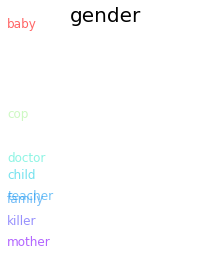

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, occupation_and_family_df, 'gender')
plt.show()

##### Verbs and Adjective


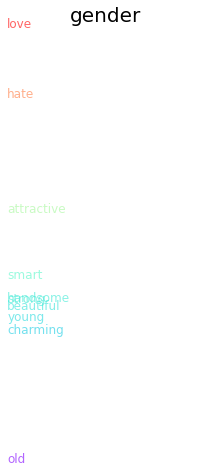

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, verb_adj_df, 'gender')
plt.show()

##### Expression Habbit


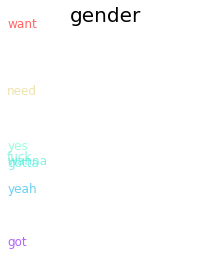

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, expression_habit_df, 'gender')
plt.show()

## More Female

### Topic Modeling

In [ ]:
preprocessed_texts = preprocess_documents(corpus_less_female)
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
ldamodel.print_topics()

[(0,
  '0.012*"like" + 0.011*"know" + 0.010*"time" + 0.010*"year" + 0.008*"think" + 0.008*"got" + 0.007*"dai" + 0.007*"look" + 0.006*"work" + 0.006*"right"'),
 (1,
  '0.020*"ye" + 0.012*"right" + 0.009*"thank" + 0.007*"know" + 0.006*"believ" + 0.006*"miss" + 0.006*"like" + 0.005*"okai" + 0.005*"think" + 0.004*"got"'),
 (2,
  '0.039*"know" + 0.026*"like" + 0.023*"think" + 0.019*"want" + 0.014*"go" + 0.014*"tell" + 0.014*"look" + 0.011*"right" + 0.010*"yeah" + 0.010*"thing"'),
 (3,
  '0.016*"go" + 0.016*"want" + 0.012*"let" + 0.011*"good" + 0.011*"time" + 0.010*"like" + 0.009*"talk" + 0.009*"right" + 0.008*"sure" + 0.007*"come"'),
 (4,
  '0.022*"know" + 0.016*"got" + 0.015*"come" + 0.011*"want" + 0.011*"need" + 0.008*"like" + 0.007*"girl" + 0.007*"love" + 0.006*"mean" + 0.006*"time"')]

### Cleaned

In [ ]:
preprocessed_texts_more_female = preprocess_documents(corpus_more_female)

In [ ]:
w2vmodel_more_female = Word2Vec(
        preprocessed_texts_more_female,
        size=7789,
        window=10)

In [ ]:
w2vmodel_more_female.wv.most_similar("power")

[('order', 0.9999989867210388),
 ('countri', 0.999998927116394),
 ('face', 0.999998927116394),
 ('turn', 0.999998927116394),
 ('write', 0.9999988675117493),
 ('pick', 0.9999988675117493),
 ('follow', 0.9999988675117493),
 ('end', 0.9999988079071045),
 ('gave', 0.9999988079071045),
 ('hand', 0.9999988079071045)]

In [ ]:
w2vmodel_more_female.wv.most_similar("woman")

[('write', 0.9999987483024597),
 ('hand', 0.9999986886978149),
 ('world', 0.9999986886978149),
 ('young', 0.9999986886978149),
 ('wonder', 0.9999986290931702),
 ('cours', 0.9999986290931702),
 ('interest', 0.9999986290931702),
 ('make', 0.9999985694885254),
 ('face', 0.9999985098838806),
 ('end', 0.9999985098838806)]

In [ ]:
w2vmodel_more_female.wv.most_similar("man")

[('woman', 0.999998152256012),
 ('young', 0.9999979734420776),
 ('interest', 0.9999976754188538),
 ('ladi', 0.9999975562095642),
 ('ey', 0.9999974370002747),
 ('beauti', 0.9999973773956299),
 ('hand', 0.9999973177909851),
 ('wonder', 0.9999972581863403),
 ('boi', 0.9999972581863403),
 ('make', 0.9999971985816956)]

In [ ]:
w2vmodel_more_female.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pick', 0.9999973177909851),
 ('clean', 0.9999973177909851),
 ('moment', 0.9999971985816956),
 ('us', 0.9999971985816956),
 ('write', 0.9999971985816956),
 ('open', 0.9999971389770508),
 ('end', 0.9999971389770508),
 ('paper', 0.9999971389770508),
 ('countri', 0.9999971389770508),
 ('worri', 0.999997079372406)]

In [ ]:
w2vmodel_more_female.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('young', 0.9999973773956299),
 ('hand', 0.9999971389770508),
 ('poor', 0.999997079372406),
 ('ladi', 0.999997079372406),
 ('small', 0.9999970197677612),
 ('follow', 0.9999970197677612),
 ('probabl', 0.9999969601631165),
 ('stupid', 0.9999969601631165),
 ('sent', 0.9999969601631165),
 ('write', 0.9999969601631165)]

### Not Cleaned

In [ ]:
tokenized_texts = []
for conv in corpus_more_female:
  tokenized_texts.append(preprocess_string(conv, CUSTOM_FILTERS))

In [ ]:
from gensim.models import Word2Vec
w2vmodel_more_female_uncleaned = Word2Vec(
        tokenized_texts,
        size=7789,
        window=10)

In [ ]:
w2vmodel_more_female_uncleaned.wv.most_similar("love")

[('hate', 0.957004964351654),
 ('asked', 0.9503551721572876),
 ('hear', 0.9396740198135376),
 ('happened', 0.9350411891937256),
 ('woke', 0.9217892289161682),
 ('wish', 0.9182931780815125),
 ('listened', 0.9172548055648804),
 ('deserve', 0.9169361591339111),
 ('lied', 0.916709840297699),
 ('say', 0.9156544804573059)]

In [ ]:
w2vmodel_more_female_uncleaned.wv.most_similar("mother")

[('father', 0.9870054125785828),
 ('alcoholic', 0.9735621809959412),
 ('name', 0.9720618724822998),
 ('passport', 0.9656678438186646),
 ('developed', 0.9489994049072266),
 ('compared', 0.9432629346847534),
 ('boy', 0.943179726600647),
 ('wounded', 0.9418613314628601),
 ('marsh', 0.9417946338653564),
 ('mac', 0.941193699836731)]

In [ ]:
w2vmodel_more_female_uncleaned.wv.most_similar("woman")

[('spray', 0.9927793741226196),
 ('husband', 0.9924948215484619),
 ('convent', 0.9918259382247925),
 ('pierce', 0.9917721152305603),
 ('smokes', 0.9915075898170471),
 ('wife', 0.9909489750862122),
 ('girl', 0.9905453324317932),
 ('thrill', 0.9902453422546387),
 ('disappeared', 0.9899625182151794),
 ('marsh', 0.9895636439323425)]

In [ ]:
w2vmodel_more_female_uncleaned.wv.most_similar("man")

[('boy', 0.9764249920845032),
 ('jacques', 0.9757789373397827),
 ('developed', 0.9753072261810303),
 ('doctor', 0.9729557633399963),
 ('stephen', 0.9719595313072205),
 ('weapon', 0.97104811668396),
 ('loser', 0.9709945917129517),
 ('fake', 0.970379114151001),
 ('believes', 0.9702553749084473),
 ('piano', 0.9695860147476196)]

In [ ]:
w2vmodel_more_female_uncleaned.most_similar(positive=['power', 'woman'], negative = ['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crop', 0.976965606212616),
 ('salary', 0.9739091396331787),
 ('hung', 0.9736359715461731),
 ('feathers', 0.9734643697738647),
 ('wilt', 0.9730786085128784),
 ('balls', 0.9723178148269653),
 ('pair', 0.9719560146331787),
 ('plain', 0.9710779786109924),
 ('fought', 0.9706246852874756),
 ('caterer', 0.9705604910850525)]

In [ ]:
w2vmodel_more_female_uncleaned.most_similar(positive=['power', 'man'], negative = ['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('con', 0.9845854043960571),
 ('possibility', 0.9831956028938293),
 ('block', 0.9812472462654114),
 ('giving', 0.9804357886314392),
 ('separate', 0.9801846742630005),
 ('sucks', 0.9798657298088074),
 ('point', 0.9792957901954651),
 ('mere', 0.9792264103889465),
 ('committee', 0.9787653088569641),
 ('register', 0.9782808423042297)]

#### Visualization

In [ ]:
Gender = dimension(w2vmodel_more_female_uncleaned, ['man','him','he'], ['woman', 'her', 'she'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
occupation_and_family = ['cop', 'killer', 'doctor', 'teacher', 'child', 'family', 'baby', 'mother',]

verb_adj = ['hate', 'love', 'smart', 'young', 'old', 'beautiful', 'attractive', 'strong', 'handsome', 'charming']

expression_habit  = ['wanna', 'want', 'need', 'gotta', 'got', 'fuck', 'yeah', 'yes']

In [ ]:
def makeDF(model, word_list):
    g = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g}, index = word_list)
    return df

In [ ]:
occupation_and_family_df = makeDF(w2vmodel_more_female_uncleaned, occupation_and_family) 
verb_adj_df = makeDF(w2vmodel_more_female_uncleaned, verb_adj) 
expression_habit_df = makeDF(w2vmodel_more_female_uncleaned, expression_habit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to 

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

##### Occupation and Family


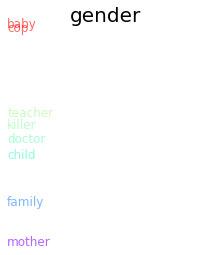

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, occupation_and_family_df, 'gender')
plt.show()

##### Verbs and Adjective


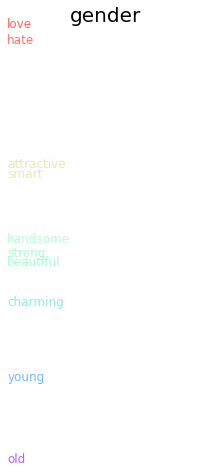

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, verb_adj_df, 'gender')
plt.show()

##### Expression Habbit


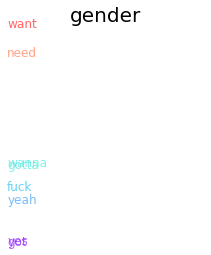

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, expression_habit_df, 'gender')
plt.show()

## Alignment

In [ ]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 18 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [ ]:
intersection_align_gensim = intersection_align_gensim(w2vmodel_only_male_uncleaned, w2vmodel_less_female_uncleaned)

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

In [ ]:
smart_procrustes_align_gensim_0 = smart_procrustes_align_gensim("woman", "woman")

TypeError: ignored

# Word2Vec Training for Whole Corpora

In [ ]:
corpus_only_male[0], corpus_less_female[0], corpus_more_female[0]

('I missed you. It says here you exposed yourself to a group of freshmen girls. It was a bratwurst.  I was eating lunch. With the teeth of your zipper?',
 "Katarina Stratford.  My, my.  You've been terrorizing Ms. Blaise again. Expressing my opinion is not a terrorist action. Well, yes, compared to your other choices of expression this year, today's events are quite mild.  By the way, Bobby Rictor's gonad retrieval operation went quite well, in case you're interested. I still maintain that he kicked himself in the balls.  I was merely a spectator. The point is Kat -- people perceive you as somewhat ...",
 'Did you change your hair? No. You might wanna think about it')

In [ ]:
corpus_all = [*corpus_only_male, *corpus_less_female, *corpus_more_female]
len(corpus_all)

83097

In [ ]:
corpus_all[51343]

"Katarina Stratford.  My, my.  You've been terrorizing Ms. Blaise again. Expressing my opinion is not a terrorist action. Well, yes, compared to your other choices of expression this year, today's events are quite mild.  By the way, Bobby Rictor's gonad retrieval operation went quite well, in case you're interested. I still maintain that he kicked himself in the balls.  I was merely a spectator. The point is Kat -- people perceive you as somewhat ..."

In [ ]:
corpus_all[75308]

'Did you change your hair? No. You might wanna think about it'

0 - 51342 in corpus_all are only male, 51343 - 75307 are less female, and 75308 - 83097 are more female


## Cleaned Version

In [86]:
from gensim.parsing.preprocessing import preprocess_documents

In [87]:
preprocessed_texts = preprocess_documents(corpus_all)

In [88]:
from gensim.models import Word2Vec


In [89]:
w2vmodel_cleaned = Word2Vec(
        preprocessed_texts,
        size=300,
        window=10)

In [90]:
w2vmodel_cleaned.wv.index2word[10]


'time'

In [ ]:
type(w2vmodel_cleaned)

gensim.models.word2vec.Word2Vec

In [ ]:
w2vmodel_cleaned.wv.most_similar("love")

[('beauti', 0.8099875450134277),
 ('hate', 0.7865305542945862),
 ('geronimo', 0.7269126772880554),
 ('wept', 0.7043155431747437),
 ('woman', 0.6999272108078003),
 ('geezer', 0.6855027079582214),
 ('marri', 0.6834906339645386),
 ('happi', 0.6688550710678101),
 ('linda', 0.6582983136177063),
 ('sex', 0.6581699848175049)]

In [ ]:
w2vmodel_cleaned.wv.most_similar("woman")

[('women', 0.8769959211349487),
 ('poor', 0.8743705153465271),
 ('beauti', 0.8599096536636353),
 ('child', 0.8574185967445374),
 ('marri', 0.84193354845047),
 ('mother', 0.8374574184417725),
 ('dream', 0.8296098113059998),
 ('children', 0.8122224807739258),
 ('wept', 0.8062140941619873),
 ('parent', 0.8049109578132629)]

In [ ]:
w2vmodel_cleaned.wv.most_similar("man")

[('old', 0.7683749794960022),
 ('napalm', 0.7125927805900574),
 ('rich', 0.7099113464355469),
 ('helper', 0.7076639533042908),
 ('poor', 0.6916558742523193),
 ('women', 0.688126802444458),
 ('cyru', 0.6790370941162109),
 ('cat', 0.6743890643119812),
 ('woman', 0.6694680452346802),
 ('holi', 0.6644185185432434)]

Well the cleaned version word2vec model doesn't make much sense for some similar words

## Non-cleaned Version

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation

In [ ]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

In [ ]:
tokenized_texts = []
for conv in corpus_all:
  tokenized_texts.append(preprocess_string(conv, CUSTOM_FILTERS))

In [ ]:
from gensim.models import Word2Vec
w2vmodel_non_cleaned_all = Word2Vec(
        tokenized_texts,
        vector_size=400,
        window=10)

## Sentence Average

#### Averaging word vectors


In [91]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [92]:
preprocessed_texts = preprocessed_texts
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

model = w2vmodel_cleaned

In [93]:
import numpy as np

In [94]:
vectors = []
def create_vector(text, model, model_type=None):
        for word in text:
            try:
                vectors.append(model.wv[word])
            except KeyError:
                pass
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)

In [107]:
male_preprocessed = preprocessed_texts[0:51342]
less_female_preprocessed = preprocessed_texts[51343:75307]
more_female_preprocessed = preprocessed_texts[75308:83097]

In [110]:
from random import sample
male_preprocessed_sample = sample(male_preprocessed,50)
less_female_preprocessed_sample = sample(less_female_preprocessed,50)
more_female_preprocessed_sample = sample(more_female_preprocessed,50)

len(male_preprocessed_sample), len(less_female_preprocessed_sample), len(more_female_preprocessed_sample)

(50, 50, 50)

In [111]:
male_vector_lst = []
for i in range (0,50):
  male_vector_lst.append(create_vector(male_preprocessed_sample[i], w2vmodel_cleaned))

In [112]:
less_female_vector_lst = []
for i in range (0,50):
  less_female_vector_lst.append(create_vector(less_female_preprocessed_sample[i], w2vmodel_cleaned))

In [113]:
more_female_vector_lst = []
for i in range (0,50):
  more_female_vector_lst.append(create_vector(more_female_preprocessed_sample[i], w2vmodel_cleaned))

##### PCA

In [ ]:
numWords = 50
targetWords = w2vmodel_cleaned.wv.index2word[:numWords]

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2vmodel_cleaned[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([[-0.5071233 ,  0.4333415 ,  0.00616709, ..., -0.18392275,
        -0.20879635,  0.846179  ],
       [ 0.11239588,  0.15977383,  0.34680635, ..., -0.37031224,
         0.38599804,  0.86333966],
       [-1.2947927 ,  0.7300754 ,  0.09971226, ..., -0.01187846,
         0.37008658,  0.3436487 ],
       ...,
       [-0.57277197, -0.20106511, -0.08657126, ...,  0.3189932 ,
         0.0334217 ,  0.23660289],
       [-1.3933754 ,  0.8395971 , -1.7471507 , ..., -0.36876294,
        -0.33924487,  0.07220302],
       [-0.28701535,  0.2707389 , -0.33722818, ...,  0.5164982 ,
         0.09835333, -0.32531396]], dtype=float32)

In [ ]:
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import matplotlib.pyplot as plt

In [145]:
pcaWords = sklearn.decomposition.PCA(n_components = 3).fit(male_vector_lst)
reducedPCA_data = pcaWords.transform(male_vector_lst)
#T-SNE is theoretically better, but you should experiment
tsneWords_male = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [146]:
pcaWords = sklearn.decomposition.PCA(n_components = 3).fit(less_female_vector_lst)
reducedPCA_data = pcaWords.transform(less_female_vector_lst)
#T-SNE is theoretically better, but you should experiment
tsneWords_less_female = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [147]:
pcaWords = sklearn.decomposition.PCA(n_components = 3).fit(more_female_vector_lst)
reducedPCA_data = pcaWords.transform(more_female_vector_lst)
#T-SNE is theoretically better, but you should experiment
tsneWords_more_female = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



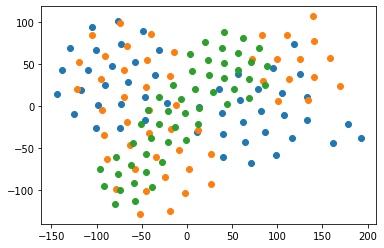

In [180]:
plt.scatter(tsneWords_male[:,0], tsneWords_male[:,1])
plt.scatter(tsneWords_less_female[:,0], tsneWords_less_female[:,1])
plt.scatter(tsneWords_more_female[:,0], tsneWords_more_female[:,1])

only_male = blue
less_female = orange
more_female = green